In [2]:
from Basic_Model import *
from Newton import *
from FF_Helpers import *
plt.rcParams["figure.figsize"] = (10,10)

In [19]:
def Simulation_FF_Adaptative(w1,w2,w3,w4,r1,r2,targets = [0,55],starting_point = [0,30],proportionnality = 0,plot = True,pert = 0,theta = -1,color = "blue",adaptive = False,ref = np.zeros((1,1)),errortype = "Kalman",gamma = 2.5,toBasis = None,NLTorque = False,SHOWL = False):
    if type(theta) == int: theta = np.zeros((len(toBasis(np.zeros(8))),2))
    Num_iter = 60
    dt = 0.01
    LOAD_ACTIVATION = 0
    st1,st2 = newton(f,df,1e-8,1000,starting_point[0],starting_point[1])
    obj1,obj2 = newton(f,df,1e-8,1000,targets[0],targets[1])
    obj3,obj4 = newton(f,df,1e-8,1000,targets[0],targets[1])

    xstart = np.array([st1,0,0,st2,0,0,obj1,0,obj2,0])
    x0 = np.array([st1,0,0,st2,0,0,obj1,0,obj2,0])
    xnonlin0 = np.concatenate((x0[:7],np.array([x0[8]])))
    Bruit = True
    NbreVar = 8
    Td = 0.066
    
    #Define Weight Matrices
    Rnonlin = np.array([[r1,0],[0,r2]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
               [0,0,0,w2,0,0,0,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
               [-w1,0,0,0,0,0,w1,0],[0,0,0,-w2,0,0,0,w2]])
    #Q = np.array([[2*w1/5+w1,0,0,-2*w1/5,0,0,w1/5-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
    #            [-2*w1/5,0,0,2*w2/5+w2,0,0,-w2/5,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
     #           [w1/5-w1,0,0,-w2/5,0,0,w1+w1/5,0],[0,0,0,-w2,0,0,0,w2]])
    Qnonlin = Q
    
    
    #Define Dynamic Matrices  
    Az = np.array([[1,dt,0,0,0,0,0,0],[0,1,dt,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,0,0,0,1,dt,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])
    Bz = np.array([[0,0],[0,0],[dt,0],[0,0],[0,0],[0,dt],[0,0],[0,0]])
    
    
    #Reverse Iterations
    #print(Qnonlin.astype(int))
    S = Qnonlin

    
    array_L = np.zeros((Num_iter-1,2,NbreVar))   
    array_S = np.zeros((Num_iter,NbreVar,NbreVar)) 
    array_S[-1] = Qnonlin
    for k in range(Num_iter-1):
        L = np.linalg.inv(Rnonlin+Bz.T@S@Bz)@Bz.T@S@Az
        array_L[Num_iter-2-k] = L
        S = Az.T@S@(Az-Bz@L)
        array_S[Num_iter-2-k] = S
        
    #print(array_L[0])
    #Feedback
    H,L,x0,A,B = np.identity(8),array_L,xnonlin0,Az,Bz
    if SHOWL:
        thetaarray = []
        for i in range(2):
            for j in range(NbreVar):
                if np.max(np.abs(L[:,i,j])) == 0: plt.plot(np.linspace(0,Num_iter-1,Num_iter-1)*0.01,L[:,i,j])
                else: plt.plot(np.linspace(0,Num_iter-1,Num_iter-1)*0.01,L[:,i,j]/np.max(np.abs(L[:,i,j])))
        plt.grid()
        plt.show()
        
    array_x = np.zeros((Num_iter,NbreVar))
    array_xhat = np.zeros((Num_iter,NbreVar))
    array_reelx = np.zeros((Num_iter,NbreVar-2)) 
    y = np.zeros((Num_iter,NbreVar))

    array_x[0] = x0.flatten()
    array_xhat[0] = x0.flatten()
    xhat = x0
    xhat2 = x0
    x = x0
    reelx = np.zeros(NbreVar-2)
    reelx[0] = x[0]
    reelx[1] = x[3]
    new_reelx = reelx
    sigma = np.identity(NbreVar)*10**-6 #Espérance de (erreur erreur^) avec erreur = x - xhat
    F = np.zeros(2)
    tau = np.zeros(2)
    a = np.ones(2)*3
    new_ref = np.zeros((Num_iter,8))
    if ref[0,0] == 0: 
        ref = new_ref
        adaptive = False
    new_ref[0] = x0
    
    
    for k in range(Num_iter-1):
        acc = np.array([(reelx[2]-array_reelx[k-1][2])/dt,(reelx[3]-array_reelx[k-1][3])/dt])
        if np.sin(reelx[0]+reelx[1])*33+np.sin(reelx[0])*30 > pert:

            if LOAD_ACTIVATION == 0:
                x[6:8] = np.array([obj3,obj4])
                xhat[6:8] = np.array([obj3,obj4])
                X = np.cos(reelx[0]+reelx[1])*33+np.cos(reelx[0])*30
                Y = np.sin(reelx[0]+reelx[1])*33+np.sin(reelx[0])*30
                LOAD_ACTIVATION = 1
                #if plot : 
                    #plt.scatter(X,Y,color = "red")
            F = Compute_f_new_version(reelx[0:2],reelx[2:4],acc,proportionnality)
        else : 
            F = 0
        

        x[0],x[1],x[3],x[4] = reelx[0],reelx[2],reelx[1],reelx[3]
        x[2] = acc[0]
        x[5] = acc[1]  
        Omega_sens,motor_noise,Omega_measure,measure_noise = Bruitage(Bruit,NbreVar) 
        y[k] = (H@x+measure_noise).flatten()
        K = A@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        v = -L[k].reshape(np.flip(B.shape))@xhat
        xhat2 = A@xhat2 + B@v + K@(y[k]-H@xhat2)
        if errortype == "Kalman":
            e = x - xhat2
        elif errortype == "Reference":
            e = x - ref[k]
        
        phi = toBasis(xhat)
        P = scipy.linalg.solve_continuous_lyapunov(A, -np.identity(A.shape[0]))
        theta = theta - gamma * phi @ e.reshape((8,1)).T@P@B/(1+np.exp((k-Num_iter/2)/Num_iter*10))
        if SHOWL : thetaarray.append(theta)
        
        if adaptive : 
            v-= (theta.T@phi).reshape(2) 
       
        
        sigma = Omega_sens + (A - K@H)@sigma@A.T
        xhat = A@xhat + B@v + K@(y[k]-H@xhat)
        x = A@x+B@v+motor_noise
        new_ref[k+1] = x

        """
        error computation
        """
        #e = x - xhat
        
            
        C = np.array([-reelx[3]*(2*reelx[2]+reelx[3])*a2*np.sin(reelx[1]),reelx[2]*reelx[2]*a2*np.sin(reelx[1])])
        Denominator = a3*(a1-a3)-a2*a2*np.cos(reelx[1])*np.cos(reelx[1])
        Minv = np.array([[a3/Denominator,(-a2*np.cos(reelx[1])-a3)/Denominator],[(-a2*np.cos(reelx[1])-a3)/Denominator,(2*a2*np.cos(reelx[1])+a1)/Denominator]])
        new_reelx[0:2] += dt*reelx[2:4]
        new_reelx[2:4] += dt*(Minv@(reelx[4:6]-Bdyn@(reelx[2:4])-C)+F)  
        M = np.array([[a1+2*a2*cos(reelx[1]),a3+a2*cos(reelx[1])],[a3+a2*cos(reelx[1]),a3]])
        Minvdot = np.array([[-a3*a2*a2*sin(2*reelx[1])*reelx[3]/(Denominator*Denominator),
                             (a2*sin(reelx[1])*reelx[3]*Denominator+(a2*cos(reelx[1])+a3)*a2*a2*sin(2*reelx[1])*reelx[3])/(Denominator*Denominator)],
                            [(a2*sin(reelx[1])*reelx[3]*Denominator+(a2*cos(reelx[1])+a3)*a2*a2*sin(2*reelx[1])*reelx[3])/(Denominator*Denominator),
                            (-2*a2*sin(reelx[1])*reelx[3]*Denominator+(2*a2*cos(reelx[1])+a1)*a2*a2*sin(2*reelx[1])*reelx[3])/(Denominator*Denominator)]])
            
        Cdot = np.array([-a2*x[5]*(2*x[1]+x[4])*sin(x[3])-a2*x[4]*(2*x[2]+x[5])*sin(x[3])
                         -a2*x[4]*x[4]*(2*x[1]+x[4])*cos(x[3]),2*x[1]*x[2]*a2*sin(x[3])+x[1]*x[1]*a2*cos(x[3])*x[4]])
        K = 1/0.06
        
        COLORS = color
        dottau = M@(v-Minvdot@M@np.array([x[2],x[5]]))+Cdot+Bdyn@np.array([x[2],x[5]])
        if NLTorque:
            Ta = 0.05
            u,newtau = Compute_Command_NL(a,dottau)
            calc = lambda u,a : a+dt*(u-a)/Td if u < a else a+dt*(u-a)/(Td+u*(Ta-Td))
            a[0] = calc(u[0],a[0])
            a[1] = calc(u[1],a[1])
            tau = tau + dt * (u-tau)*K
           
            new_reelx[4:6] += dt*newtau
        else:
            u = dottau/K + tau 
            tau = tau + dt * (u-tau)*K
            new_reelx[4:6] += dt*K*(u-reelx[4:6])
        
            
        array_xhat[k+1] = xhat.flatten()
        array_x[k+1]= x.flatten()
        array_reelx[k+1] = new_reelx.flatten()
        reelx = new_reelx 
        #print(array_x[k-1,2],((array_x[k]-array_x[k-1])/dt)[1])   

#Plot
    x0 = xstart
    reelx = array_reelx.T[:,1:][:,::1]
    X = np.cos(reelx[0]+reelx[1])*33+np.cos(reelx[0])*30
    Y = np.sin(reelx[0]+reelx[1])*33+np.sin(reelx[0])*30
    if SHOWL:
        plt.grid()
        for i in range(4):
            for j in range(2):
                plt.plot(np.linspace(0,0.06,59),np.array(thetaarray)[:,i,j]/np.max(np.array(thetaarray)[:,i,j]))
        plt.show()
    if plot : 
        lw = .8 if (COLORS == "black" or COLORS == "orange") else .1
        plt.plot(X,Y,color = COLORS,linewidth = lw,label = "Adaptive Controller")
    return theta,new_ref,x@Q@x

def run(Num_Sim = 100,Basis = phi_arm,error_func = "Kalman",gamma_choice = 3.5,plotting = 1,factor = 0,NLTorque = False,SHOWL = False):
    theta,reelx,cost = Simulation_FF_Adaptative(1e7,1e7,1000,1000,1e-6,1e-6,starting_point= [0,29.4],targets = [0,46.1],proportionnality=factor,plot = False,pert = 69,adaptive = True,errortype=error_func,toBasis=Basis,NLTorque=NLTorque)
    oldcost = cost
    thetaarray = []
    for sim in range(Num_Sim-1):
        color = "orange" if sim < 5 else "green"
        if sim > Num_Sim - 4: color = "black"
        willIplot = 1 if plotting in [1,4] else 0
        theta,useless,cost = Simulation_FF_Adaptative(1e7,1e7,1000,1000,1e-6,1e-6,starting_point= [0,29.4],targets = [0,46.1],proportionnality=factor,plot = willIplot,pert = 29,theta = theta,color = color,adaptive = True,ref = reelx,errortype = error_func,gamma = gamma_choice,toBasis=Basis,NLTorque=NLTorque,SHOWL = SHOWL)
        thetaarray.append(theta)
    if plotting > 0:
        theta,useless,cost = Simulation_FF_Adaptative(1e7,1e7,1000,1000,1e-6,1e-6,starting_point= [0,29.4],targets = [0,46.1],proportionnality=factor,plot = True,pert = 29,theta = theta,color = "black",adaptive = True,ref = reelx,errortype = error_func,gamma = gamma_choice,toBasis=Basis,NLTorque=NLTorque)
        plt.axis("equal")   
        plt.xlabel,plt.ylabel ="x [cm]","y [cm]"
        plt.grid()
        plt.scatter([0],[46.1],color = "red",marker= "s")
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        plt.show()

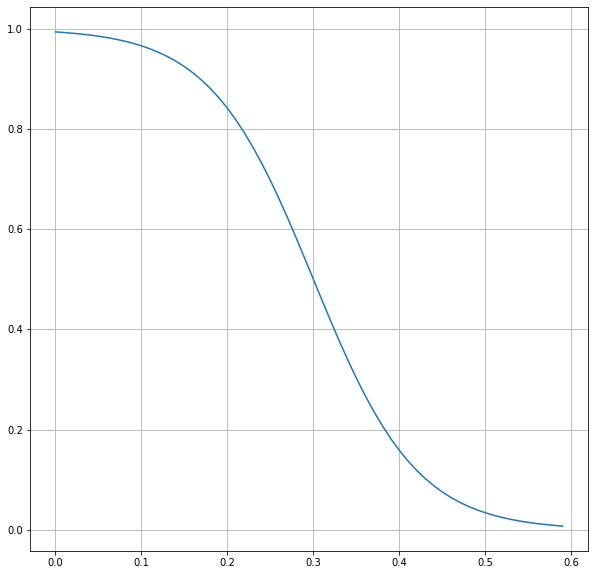

In [35]:
k = np.linspace(0,59,60)
Num_iter = 60
plt.grid()
plt.plot(k*0.01,(1/(1+np.exp((k-Num_iter/2)/Num_iter*10))))
plt.show()

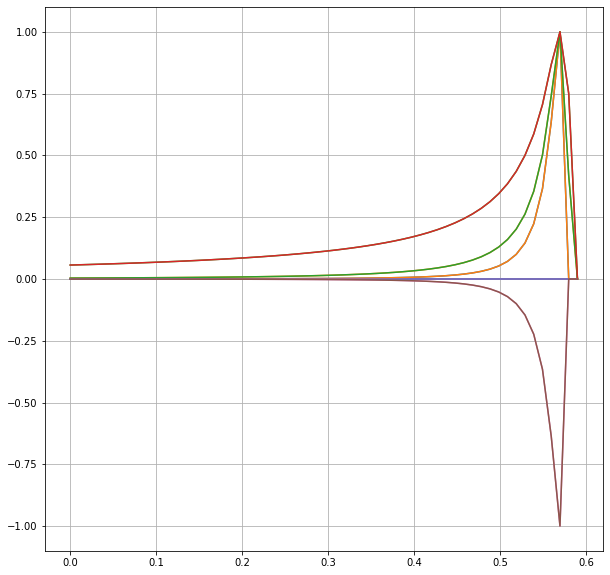

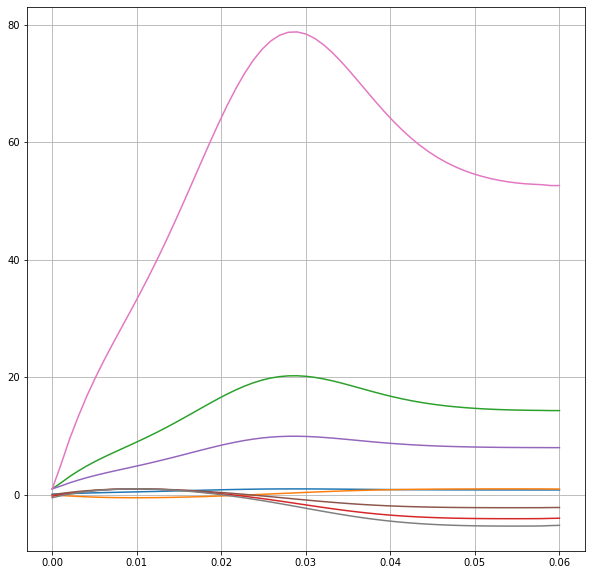

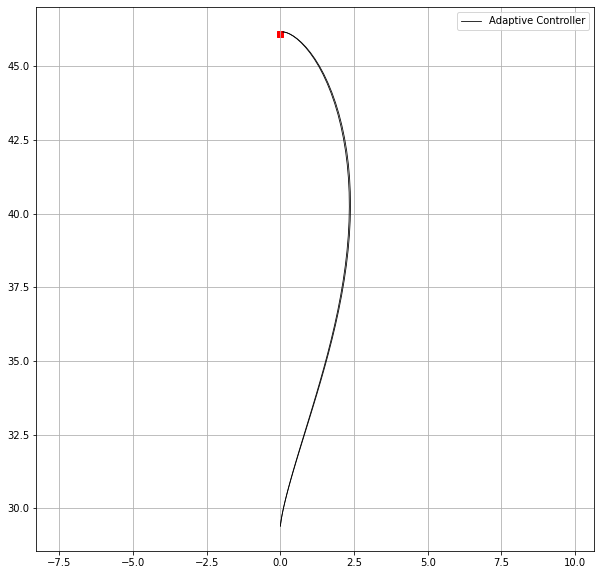

In [94]:
run(Num_Sim = 2,Basis = phi_arm,error_func = "Kalman",gamma_choice = 3.5,factor = OPTIMAL_FACTORS[11],SHOWL = True)

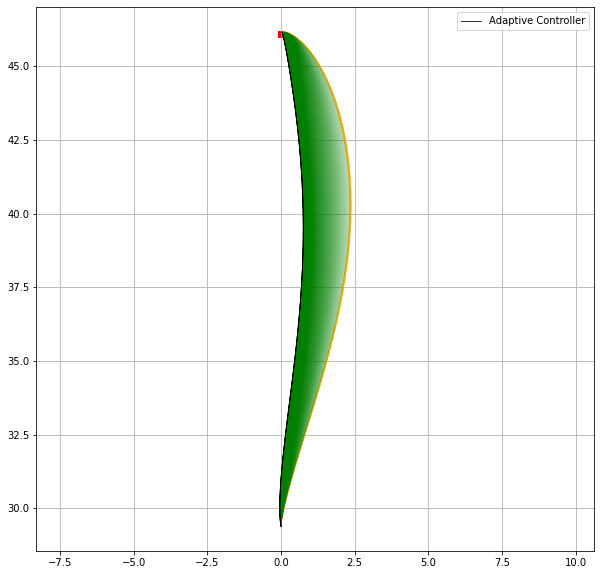

In [75]:
run(Num_Sim = 1000,Basis = phi_arm,error_func = "Kalman",gamma_choice = 1,factor = OPTIMAL_FACTORS[11])
#run(Num_Sim = 100,Basis = phi_arm,error_func = "Kalman",gamma_choice = .1,factor = OPTIMAL_FACTORS[11],NLTorque=True)

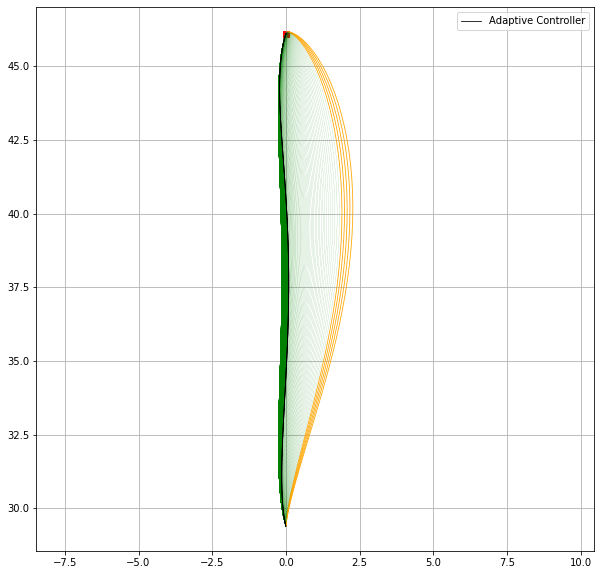

In [77]:
run(Num_Sim = 1000,Basis = phi_arm,error_func = "Reference",gamma_choice = 20,factor = OPTIMAL_FACTORS[11])

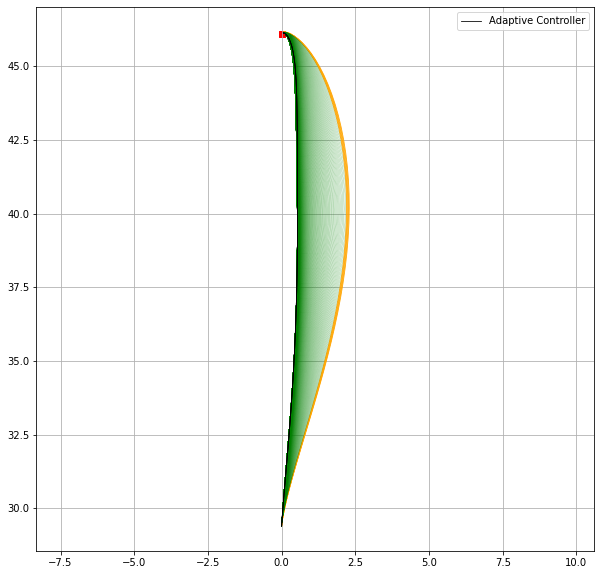

In [73]:
run(Num_Sim = 1000,Basis = phi_extended,error_func = "Kalman",gamma_choice = .1,factor = OPTIMAL_FACTORS[11])

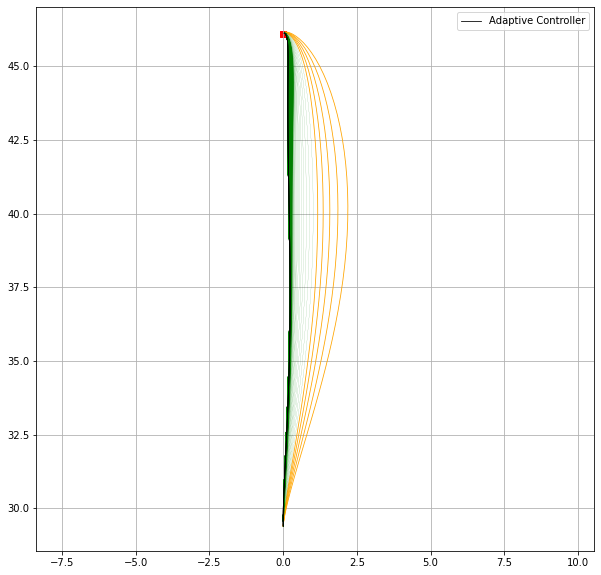

In [78]:
run(Num_Sim = 1000,Basis = phi_extended,error_func = "Reference",gamma_choice = 1,factor = OPTIMAL_FACTORS[11])

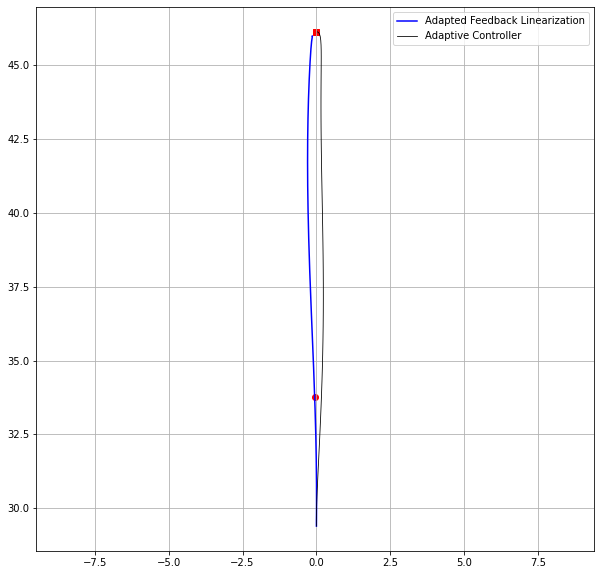

In [13]:
X,Y = Simulation_FF(1e7,1e7,1000,1000,0,1e-6,1e-6,1,starting_point= [0,29.4],targets = [0,46.1],proportionnality=OPTIMAL_FACTORS[11],plot = True,pert = 33.75)
run(Num_Sim = 3000,Basis = phi_extended,error_func = "Reference",gamma_choice = .3,plotting = 2,factor = OPTIMAL_FACTORS[11])

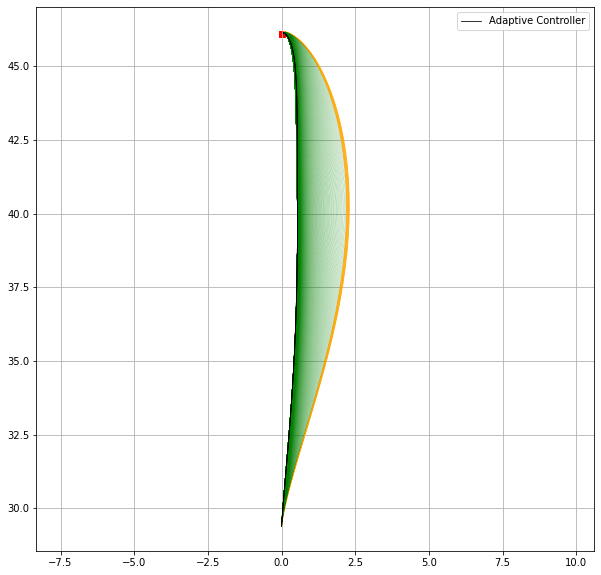

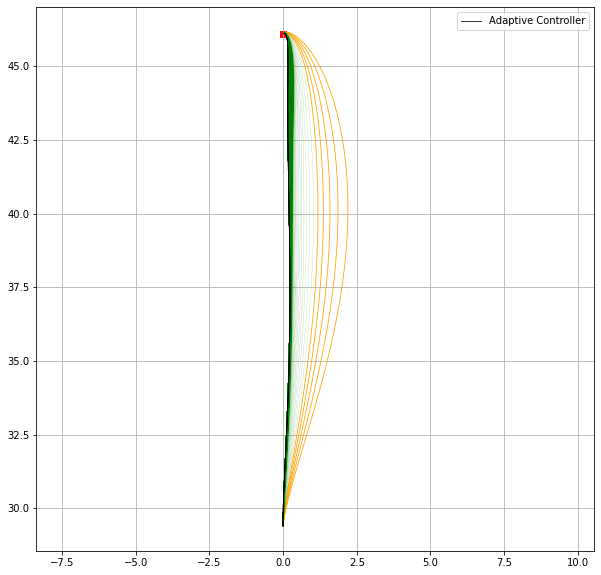

In [20]:
def New_Basis(x):
    return x.reshape((8,1))

run(Num_Sim = 1000,Basis = New_Basis,error_func = "Kalman",gamma_choice = .1,factor = OPTIMAL_FACTORS[11],NLTorque=False)
run(Num_Sim = 1000,Basis = New_Basis,error_func = "Reference",gamma_choice = 1,factor = OPTIMAL_FACTORS[11],NLTorque=False)

c:\Users\talex\Desktop\Mémoire\Code\Basic_Model.py:53: RuntimeWarning: invalid value encountered in scalar power
  return np.exp(-(a/(0.56*Nf))**Nf)*Nf/Td*(1/(0.56*Nf))**Nf*a**(Nf-1)


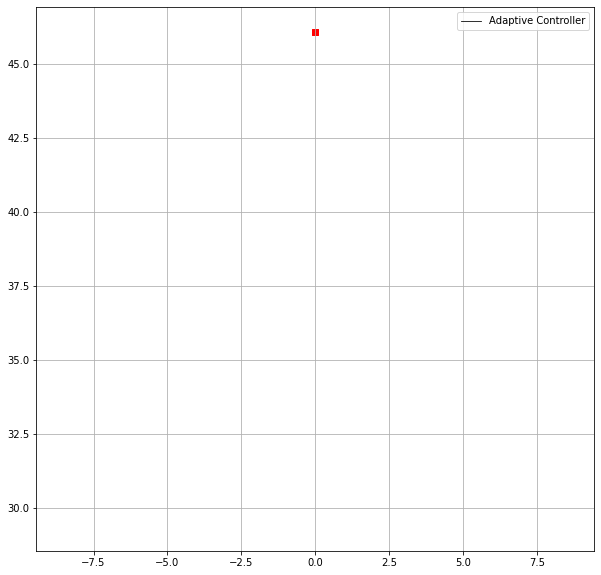

In [21]:
def New_Basis(x):
    return x.reshape((8,1))
run(Num_Sim = 1000,Basis = New_Basis,error_func = "Kalman",gamma_choice = .1,factor = OPTIMAL_FACTORS[11],NLTorque=True)
#run(Num_Sim = 1000,Basis = New_Basis,error_func = "Reference",gamma_choice = 1,factor = OPTIMAL_FACTORS[11])